---

#Final Team Project: Object Detection in Fashion

##Final Project Team 1 - AAI-521: Intro to Computer Vision

##Jason Raimondi, Abdul Shariq, and Kayla Wright

##2023-12-11

###AAI521_Team1_Fashion.ipynb

###Data Source:

Kaggle - Colorful Fashion Dataset For Object Detection

https://www.kaggle.com/datasets/nguyngiabol/colorful-fashion-dataset-for-object-detection

###GitHub Repository:

https://github.com/jeraimondi/aai-cv-obj-detect-fashion

###References:

https://keras.io/api/keras_cv/

https://keras.io/api/keras_cv/models/

https://keras.io/api/keras_cv/models/tasks/retinanet/

https://keras.io/guides/keras_cv/object_detection_keras_cv/

---

# Environment Prep

## Install Required Packages

In [1]:
!pip install keras-cv

## Load Required Libraries

In [2]:
# ignore warnings during code execution
import warnings
warnings.filterwarnings('ignore')

import cv2 # computer vision
import keras_cv # computer vision
from keras_cv import bounding_box # convert format function
from keras_cv import visualization # gallery plotting
from keras_cv.metrics import BoxCOCOMetrics # custom metrics
import keras_core as keras # core keras
from keras.models import load_model # load model
import matplotlib.pylab as plt # plotting
import numpy as np # array manipulation
import random # random number generator
import shutil # file operations
import tensorflow as tf  # machine learning platform
import tqdm # progress bars
from google.colab import drive # connect to drive storage
from natsort import natsorted # natural sorting of numeric files
from os import listdir # get list of files/directories
from sklearn.model_selection import train_test_split # splitter function
from tensorflow.keras.optimizers import SGD # stochastic gradient descent
from zipfile import ZipFile # dataset extraction

Using TensorFlow backend


For reference, let's print the library versions.

In [3]:
# print library versions
print('Library Versions:')
print('-----------------')
print('TensorFlow:', tf.__version__)
print('Keras Core:', keras.__version__)
print('KerasCV:', keras_cv.__version__)
print('OpenCV:', cv2.__version__)

Library Versions:
-----------------
TensorFlow: 2.14.0
Keras Core: 0.1.7
KerasCV: 0.7.1
OpenCV: 4.8.0


## Set Random Seeds

In [4]:
# set global random seeds for reproducibility
seed = 1234
random.seed(seed)
np.random.seed(seed)

## Verify GPU Availability

In [5]:
# set to True when using GPU
use_gpu = True

if use_gpu == True:
    # ensure GPU is available before proceeding
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif use_gpu == False:
    print('Bypassing GPU check.')
    print('Set use_gpu to True if wanting to use GPU.')

Found GPU at: /device:GPU:0


# Data Exploration

## Upload and Extract Dataset

In [6]:
# connect google drive
drive.mount('/content/drive') # uncomment to mount google drive
path_dataset_archive = '/content/drive/MyDrive/Colab Notebooks/Data/archive.zip'

# extract dataset from zipped archive
with ZipFile(path_dataset_archive, 'r') as myzip:
  myzip.extractall()

Mounted at /content/drive


## Display Sample Images from Dataset

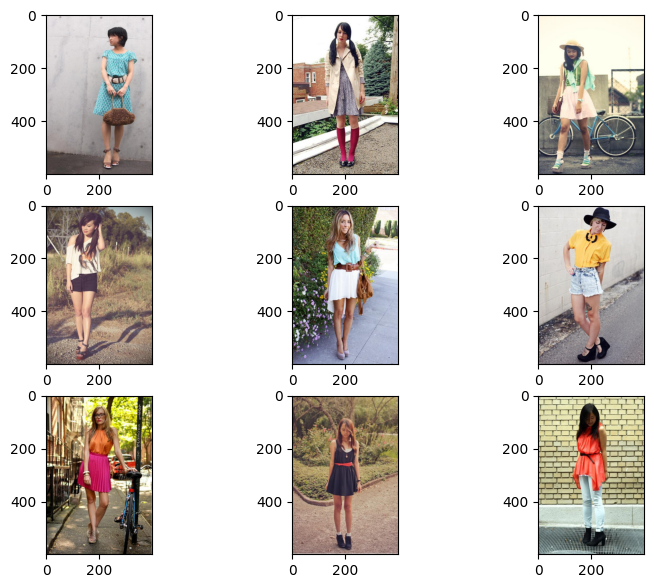

In [7]:
# define paths
dir_data = '/content/colorful_fashion_dataset_for_object_detection/'
dir_img = dir_data + 'JPEGImages/'
dir_annotations = dir_data + 'Annotations_txt/'

# create file lists of images and annotations
list_of_images = natsorted(listdir(dir_img))
list_of_annotations =  natsorted([file for file in listdir(dir_annotations) if file != 'classes.txt'])

# check number of image and annotation files match
assert len(list_of_images) == len(list_of_annotations)

# create figure
fig=plt.figure(figsize=(9, 7))

# create subplots
for i in range(9): # first 9
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(dir_img + list_of_images[i]) # read image with OpenCV
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB color space
    plt.imshow(img_RGB)

# show figure
plt.show()

# Pre-Trained Model

## Image Before Inference

142662880/142662880 [==============================] - 11s 0us/step


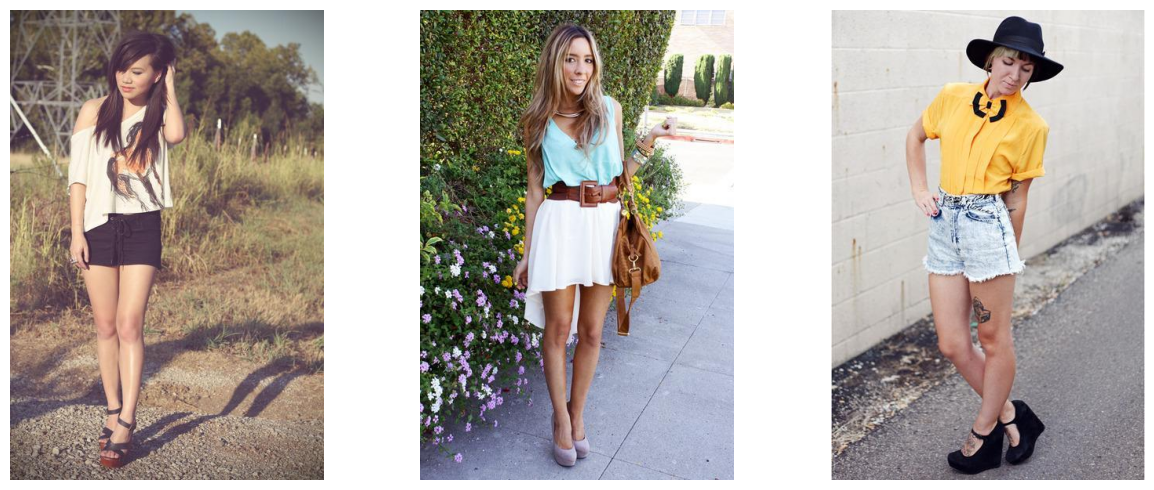

In [8]:
# define bounding box format
bounding_box_format = 'XYXY'

# define model from preset config and weights
pt_model = keras_cv.models.RetinaNet.from_preset('retinanet_resnet50_pascalvoc', bounding_box_format=bounding_box_format)

# function to get samples of images converted to RGB
def get_image_samples(sample_size):
    image_samples = []
    for i in range(sample_size):
        img = cv2.imread(dir_img + list_of_images[i+3]) # read image with OpenCV
        img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB color space
        image_samples.append(img_RGB)
    return np.array(image_samples)

# call function to get batch of image samples
sample_size = 3
image_samples = get_image_samples(sample_size)

# plot image gallery
_ = visualization.plot_image_gallery(
    image_samples,
    value_range=(0, 255),
    rows=1,
    cols=sample_size,
    scale=5,
)

## Image After Inference

In [9]:
# define pascalvoc class ids
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]

# define dictionary of class mappings
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [10]:
# function to convert bounding boxes
# specify original format, 'YOLO' or 'PASCALVOC' for correct conversion
def convert_bbox(box, original_size, new_size, format='YOLO'):

    # obtain sizes of original and new image
    original_width, original_height = original_size
    new_width, new_height = new_size

    # calculate target dimensions while maintaining aspect ratio
    aspect_ratio_original = original_width / original_height
    target_width_by_height = new_height * aspect_ratio_original

    # calculate padding added in x dimension
    x_pad_size = new_width - target_width_by_height

    # calculate scaling factors
    x_scale = (new_width - x_pad_size) / original_width
    y_scale = new_height / original_height

    # Convert YOLO format to PASCALVOC (XYXY)
    if format == 'YOLO':
        # unpack box coordinates
        x, y, w, h = box

        # obtain coordinates
        xmin = int((x - w / 2) * original_width)
        ymin = int((y - h / 2) * original_height)
        xmax = int((x + w / 2) * original_width)
        ymax = int((y + h / 2) * original_height)

        # scale coordinates
        xmin = int(np.round(xmin * x_scale))
        ymin = int(np.round(ymin * y_scale))
        xmax = int(np.round(xmax * x_scale))
        ymax = int(np.round(ymax * y_scale))

        # return updated bbox
        return np.array([xmin, ymin, xmax, ymax])

    elif format == 'PASCALVOC':
        # unpack box coordinates
        rel_left, rel_top, rel_right, rel_bottom = box

        # convert to absolute coordinates based on original_size
        left = (rel_left / 100) * original_width
        top = (rel_top / 100) * original_height
        right = (rel_right / 100) * original_width
        bottom = (rel_bottom / 100) * original_height

        # convert to relative coordinates based on new_size
        new_left = (left / (new_width - x_pad_size/2)) * 100
        new_top = (top / new_height) * 100
        new_right = (right / (new_width - x_pad_size/2)) * 100
        new_bottom = (bottom / new_height) * 100

        # return updated bbox
        return np.array([new_left, new_top, new_right, new_bottom])

1/1 [==============================] - 18s 18s/step


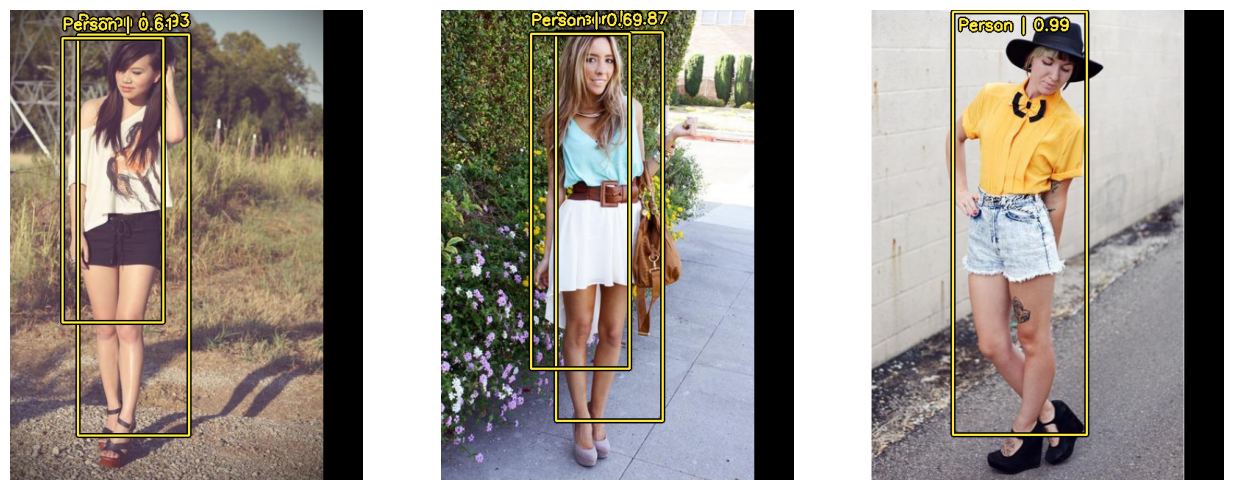

In [11]:
# define original image size and new size
# resizing required by models
original_size = (400, 600)
new_size = (480, 640)

# resizing layer to resize and pad image
inference_resizing = keras_cv.layers.Resizing(
    new_size[1], new_size[0], pad_to_aspect_ratio=True, bounding_box_format=bounding_box_format
)

# create batch of images for inference
image_samples = inference_resizing(image_samples)

# perform inference
y_pred = pt_model.predict(image_samples)

# convert pascalvoc bboxes
y_pred['boxes'] = [
    [convert_bbox(box, original_size, new_size, format='PASCALVOC') for box in image]
    for image in y_pred['boxes']
]

# plot image gallery
_ = visualization.plot_bounding_box_gallery(
    image_samples,
    value_range=(0, 255),
    rows=1,
    cols=sample_size,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format=bounding_box_format,
    class_mapping=class_mapping,
)

## Inference Without NonMax Suppression

1/1 [==============================] - 2s 2s/step


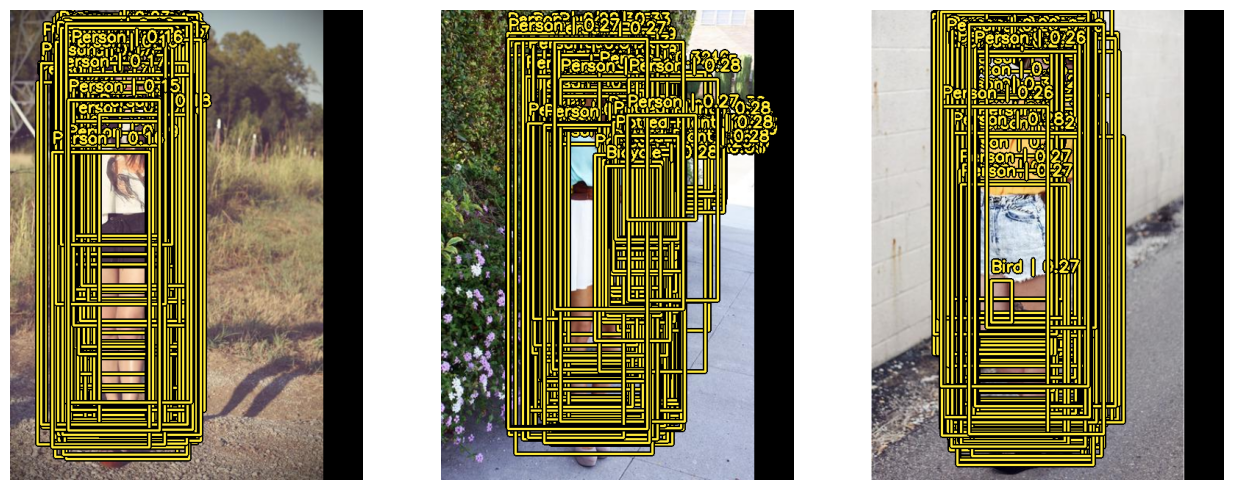

In [12]:
# NonMaxSuppression (NMS) layer to disable NMS
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format=bounding_box_format,
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)

# disable NMS for pre-trained model
pt_model.prediction_decoder = prediction_decoder

# perform inference
y_pred = pt_model.predict(image_samples)

# convert pascalvoc bboxes
y_pred['boxes'] = [
    [convert_bbox(box, original_size, new_size, format='PASCALVOC') for box in image]
    for image in y_pred['boxes']
]

# plot image gallery
_ = visualization.plot_bounding_box_gallery(
    image_samples,
    value_range=(0, 255),
    rows=1,
    cols=sample_size,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format=bounding_box_format,
    class_mapping=class_mapping,
)

## Inference With NonMax Suppression

1/1 [==============================] - 2s 2s/step


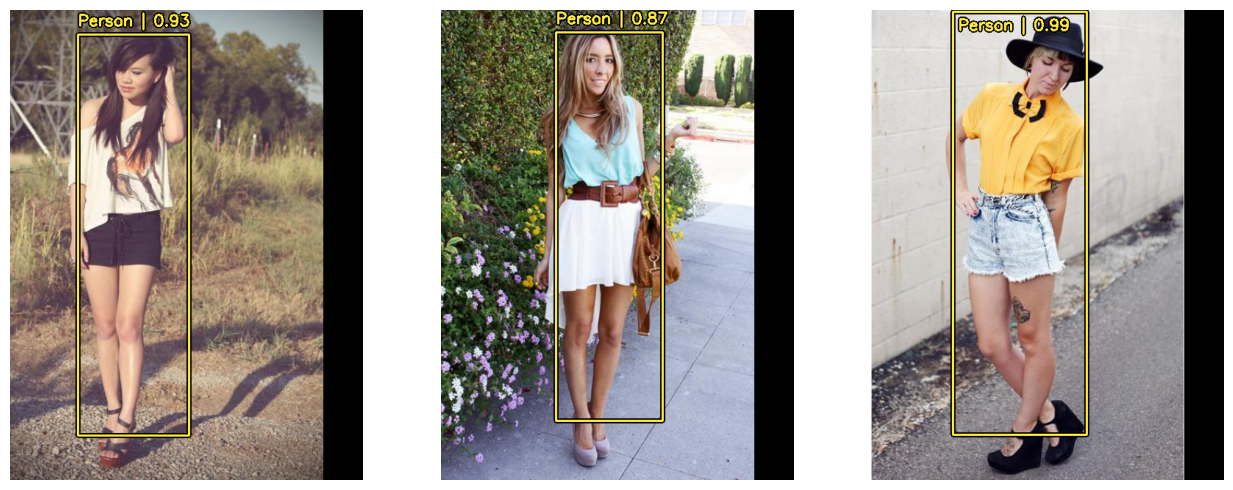

In [13]:
# enable NMS, tune for best results
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format=bounding_box_format,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.7,
)

# enable NMS for pre-trained model
pt_model.prediction_decoder = prediction_decoder

# perform inference
y_pred = pt_model.predict(image_samples)

# convert pascalvoc bboxes
y_pred['boxes'] = [
    [convert_bbox(box, original_size, new_size, format='PASCALVOC') for box in image]
    for image in y_pred['boxes']
]

# plot image gallery
_ = visualization.plot_bounding_box_gallery(
    image_samples,
    value_range=(0, 255),
    rows=1,
    cols=sample_size,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format=bounding_box_format,
    class_mapping=class_mapping,
)

# Prepare Data

## Obtain Class Names

In [14]:
# obtain class names from 'classes.txt' file included with dataset
file_labels = open(dir_annotations + 'classes.txt', 'r')
data_labels = file_labels.read()
class_ids = data_labels.split('\n')
file_labels.close()

# create class mapping dictionary for fashion dataset
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# print dataset info
print('There are', len(list_of_images), 'total images.')
print('There are', len(list_of_annotations), 'total annotation files.\n')
print('There are', len(class_ids), 'total classes.\n')
print('Class Mapping:', class_mapping, '\n')

There are 2682 total images.
There are 2682 total annotation files.

There are 10 total classes.

Class Mapping: {0: 'sunglass', 1: 'hat', 2: 'jacket', 3: 'shirt', 4: 'pants', 5: 'shorts', 6: 'skirt', 7: 'dress', 8: 'bag', 9: 'shoe'} 



## Split into Train/Val/Test Datasets

### Split Files

In [15]:
# initialize empty lists for files
trainval_images, trainval_annotations = [], []
test_images, test_annotations = [], []

# obtain file numbers designated for 'trainval' datasets
file_trainval = open(dir_data + 'ImageSets/Main/trainval.txt', 'r')
data_trainval = file_trainval.read()
file_nums_trainval = data_trainval.split('\n')
file_trainval.close()

# obtain file numbers designated for 'test' dataset
file_test = open(dir_data + 'ImageSets/Main/test.txt', 'r')
data_test = file_test.read()
file_nums_test = data_test.split('\n')
file_test.close()

# split images and labels to appropriate datasets per dataset files
for i in range(len(list_of_images)):
    if list_of_images[i].split('.jpg')[0] in file_nums_trainval:
        trainval_images.append(list_of_images[i])
        trainval_annotations.append(list_of_annotations[i])
    elif list_of_images[i].split('.jpg')[0] in file_nums_test:
        test_images.append(list_of_images[i])
        test_annotations.append(list_of_annotations[i])

# assert we still have the correct total of images and labels
assert len(trainval_images) + len(test_images) == len(list_of_images)
assert len(trainval_annotations) + len(test_annotations) == len(list_of_annotations)

# print dataset sizes before splitting
print('Dataset sizes BEFORE splitting:')
print('-------------------------------')
print('trainval_images:', len(trainval_images))
print('test_images:', len(test_images), '\n')

# split trainval dataset into separate training (80%) and validation (20%) sets
train_images, val_images, train_annotations, val_annotations = train_test_split(trainval_images, trainval_annotations, test_size=0.2, random_state=0)

# print dataset sizes after splitting
print('Dataset sizes AFTER splitting:')
print('-------------------------------')
print('train_images:', len(train_images))
print('val_images:', len(val_images))
print('test_images:', len(test_images))

Dataset sizes BEFORE splitting:
-------------------------------
trainval_images: 2145
test_images: 537 

Dataset sizes AFTER splitting:
-------------------------------
train_images: 1716
val_images: 429
test_images: 537


### Preprocess Files

In [16]:
# function to preprocess image files
def preprocess_image_file(image_file):

    # preprocess image
    image_path = dir_img + image_file
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resize image to new size
    image_resizing = keras_cv.layers.Resizing(
    new_size[1], new_size[0], pad_to_aspect_ratio=True, bounding_box_format=bounding_box_format
    )

    image = image_resizing([image])

    return image

# function to preprocess annotation files
def preprocess_annotation_file(annotation_file):

    annotation_path = dir_annotations + annotation_file

    bboxes, classes = [], []
    with open(annotation_path, 'r') as file_txt:
        for line in file_txt:
            data_txt = line.split()
            cls = int(data_txt[0])
            x = float(data_txt[1])
            y = float(data_txt[2])
            w = float(data_txt[3])
            h = float(data_txt[4])

            # convert bbox coordinates from YOLO format
            bb = convert_bbox([x, y, w, h], original_size, new_size)

            bboxes.append(bb)
            classes.append(cls)

    return (bboxes, classes)

# function to preprocess files
def preprocess_dataset_files(images, annotations):
    processed_images = []
    sample_bboxes = []
    sample_classes = []
    for i in range(len(images)):
        processed_images.append(preprocess_image_file(images[i]))
        annotation_bboxes, annotation_classes = (preprocess_annotation_file(annotations[i]))
        sample_bboxes.append(annotation_bboxes)
        sample_classes.append(annotation_classes)

    # preprocessed images
    processed_images = np.array(processed_images)
    processed_images = np.squeeze(processed_images)

    # iterate through all bboxes for each sample
    boxes = []
    classes = []
    for i in range(len(sample_bboxes)):
        boxes.append(sample_bboxes[i])
        classes.append(sample_classes[i])

    # convert boxes and classes to ragged tensors
    boxes_ragged = tf.ragged.constant(boxes, dtype=tf.float32)
    classes_ragged = tf.ragged.constant(classes, dtype=tf.float32)

    # combine ragged tensors into a dictionary
    labels = {
        'boxes': boxes_ragged,
        'classes': classes_ragged
    }

    # return preprocessed images and labels
    return processed_images, labels

In [17]:
# call function to preprocess train, val, and test dataset files
train_images, train_labels = preprocess_dataset_files(train_images, train_annotations)
val_images, val_labels = preprocess_dataset_files(val_images, val_annotations)
test_images, test_labels = preprocess_dataset_files(test_images, test_annotations)

## Convert to TensorFlow Datasets

In [18]:
# function to convert to tf dataset
def create_tf_dataset(images, labels):

    # create and return a tf dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

# call function to create train, val, and test datasets
train_ds = create_tf_dataset(train_images, train_labels)
val_ds = create_tf_dataset(val_images, val_labels)
test_ds = create_tf_dataset(test_images, test_labels)

In [19]:
# define batch size
BATCH_SIZE = 16

# shuffle training dataset
train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [20]:
# create dataset batches for training and validation
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

In [21]:
# function to visualize dataset
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

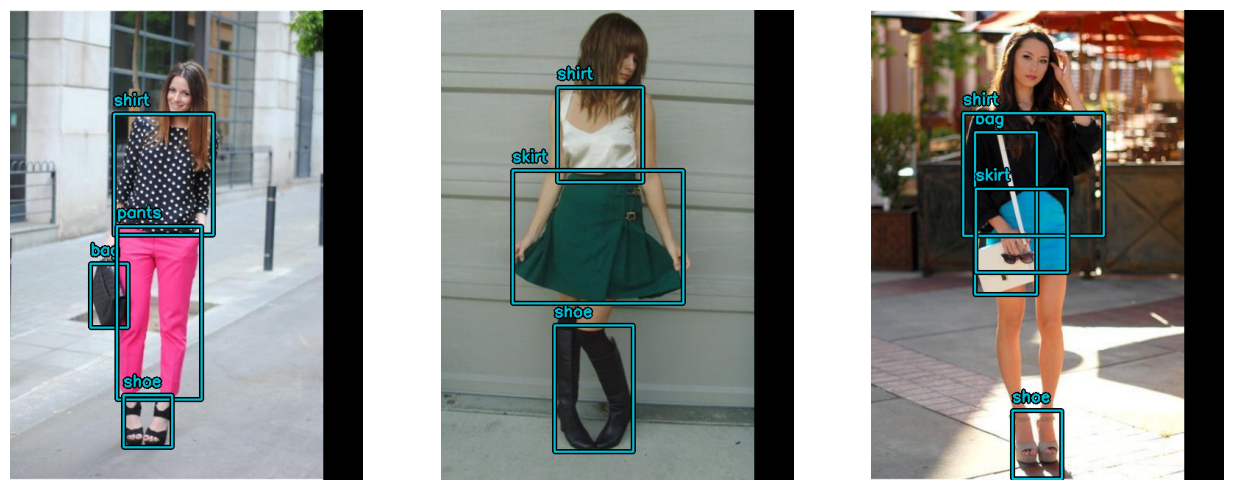

In [22]:
# visualize training dataset
visualize_dataset(
    train_ds, bounding_box_format=bounding_box_format, value_range=(0, 255), rows=1, cols=3
)

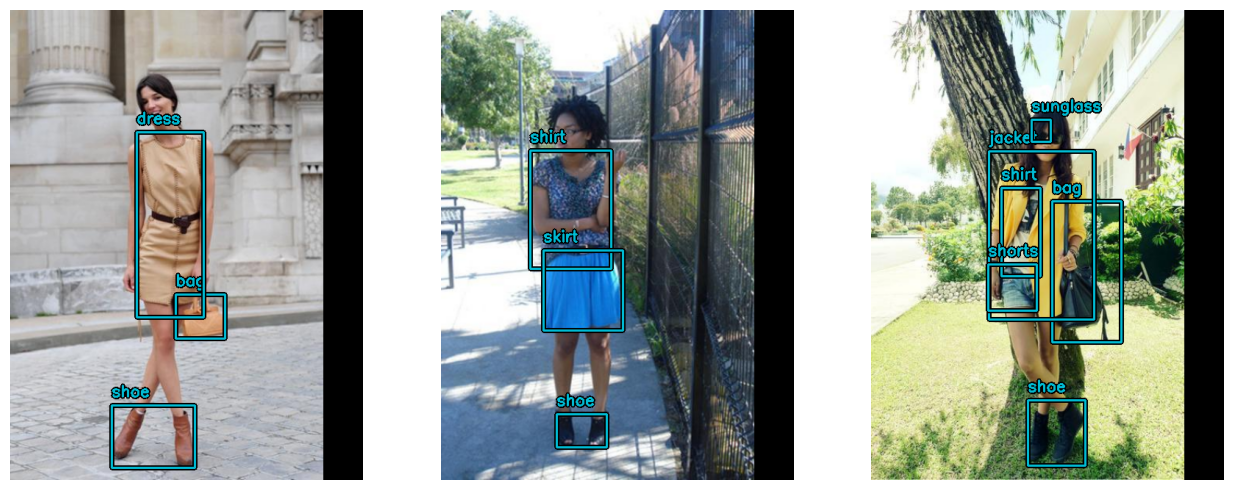

In [23]:
# visualize validation dataset
visualize_dataset(
    val_ds, bounding_box_format=bounding_box_format, value_range=(0, 255), rows=1, cols=3
)

## Data Augmentation

In [24]:
# I think let's consider adding data augmentation later for model improvements
"""
augmenter = keras.Sequential(
    layers=[
        #keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=bounding_box_format),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format=bounding_box_format
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format=bounding_box_format, value_range=(0, 255), rows=1, cols=3
)
"""

'\naugmenter = keras.Sequential(\n    layers=[\n        #keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=bounding_box_format),\n        keras_cv.layers.JitteredResize(\n            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format=bounding_box_format\n        ),\n    ]\n)\n\ntrain_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)\nvisualize_dataset(\n    train_ds, bounding_box_format=bounding_box_format, value_range=(0, 255), rows=1, cols=3\n)\n'

In [25]:
# prefetch data prior to training for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Build Model Architecture

## RetinaNet Model

In [26]:
# function to visualize detections during inference
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=5,
        rows=3,
        cols=3,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [33]:
# prepare additional parameters for training

# declare variables
NUM_CLASSES = len(class_ids) # 10 total
NUM_EPOCHS = 20

# define optimizer
optimizer = SGD(
    learning_rate=0.01,
    momentum=0.9,
    global_clipnorm=10.0
)

# class for visualizing detections
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model,
            bounding_box_format=bounding_box_format,
            dataset=val_ds
        )

# class for custom COCO metrics
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format=bounding_box_format,
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        # ragged tensor workaround
        y_pred = keras_cv.bounding_box.to_dense(y_pred, max_boxes=16)
        y_true = keras_cv.bounding_box.to_dense(y_true, max_boxes=16)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

# define path to save model checkpoints
checkpoint_path='fashion_model_best'

# define checkpoint callback to only save best model
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# define callbacks
callbacks = [

checkpoint_callback

# not working currently
#EvaluateCOCOMetricsCallback(val_ds),

# visualize results after each epoch
#VisualizeDetections()

]

In [28]:
# define backbone model - ResNet50_Imagenet
backbone = keras_cv.models.ResNetBackbone.from_preset('resnet50_imagenet')

# build RetinaNet model using backbone
model = keras_cv.models.RetinaNet(
    backbone=backbone,
    num_classes=NUM_CLASSES,
    bounding_box_format=bounding_box_format,
)
# keep false to only train new model top
model.backbone.trainable = False

# compile the model
model.compile(
    classification_loss='focal',
    box_loss='smoothl1',
    optimizer=optimizer,
    metrics=None, # using custom metrics
)

# trian the model
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS) # without callbacks
#history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=callbacks) # with callbacks, was resulting in error

94657128/94657128 [==============================] - 11s 0us/step
Epoch 1/20
107/107 [==============================] - 116s 922ms/step - loss: 1.1118 - box_loss: 0.5474 - classification_loss: 0.5644 - percent_boxes_matched_with_anchor: 0.3039 - val_loss: 0.8500 - val_box_loss: 0.4371 - val_classification_loss: 0.4129 - val_percent_boxes_matched_with_anchor: 0.2973
Epoch 2/20
107/107 [==============================] - 92s 869ms/step - loss: 0.7284 - box_loss: 0.3790 - classification_loss: 0.3495 - percent_boxes_matched_with_anchor: 0.2990 - val_loss: 0.6875 - val_box_loss: 0.3530 - val_classification_loss: 0.3345 - val_percent_boxes_matched_with_anchor: 0.2973
Epoch 3/20
107/107 [==============================] - 88s 833ms/step - loss: 0.6244 - box_loss: 0.3219 - classification_loss: 0.3025 - percent_boxes_matched_with_anchor: 0.3062 - val_loss: 0.6348 - val_box_loss: 0.3366 - val_classification_loss: 0.2982 - val_percent_boxes_matched_with_anchor: 0.2973
Epoch 4/20
107/107 [==========

In [29]:
# print model summary
print(model.summary())

Model: "retina_net_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 images (InputLayer)         [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_1 (Functional)        {'P3': (None, None, None,    2356115   ['images[0][0]']              
                             512),                        2                                       
                              'P4': (None, None, None,                                            
                             1024),                                                               
                              'P5': (None, None, None,                                            
                             2048)}                                                    

# Inference on Sample Images




## Save/Load Pre-Trained Model

In [30]:
# set to True to save model after training
SAVE_MODEL = False

if SAVE_MODEL == True:

    # save model
    model.save('fashion_model_1')

    # Create a zip archive
    shutil.make_archive('fashion_model_archive', 'zip', 'fashion_model_1')

    # Source and destination paths
    source_zip_path = 'fashion_model_archive.zip'
    destination_folder = '/content/drive/MyDrive/models/fashion_model/'

    # Move the zip file to the destination folder
    shutil.move(source_zip_path, destination_folder)

# set to True to load a previously saved model
LOAD_MODEL = False

if LOAD_MODEL == True:

    # path to saved model zipped archive file
    path_model_archive = '/content/drive/MyDrive/models/fashion_model/fashion_model_1.zip'

    # extract dataset from zipped archive
    with ZipFile(path_model_archive, 'r') as myzip:
      myzip.extractall()

    # load model
    loaded_model = load_model('fashion_model_1')

## Evaluate Model on Sample Images

1/1 [==============================] - 2s 2s/step


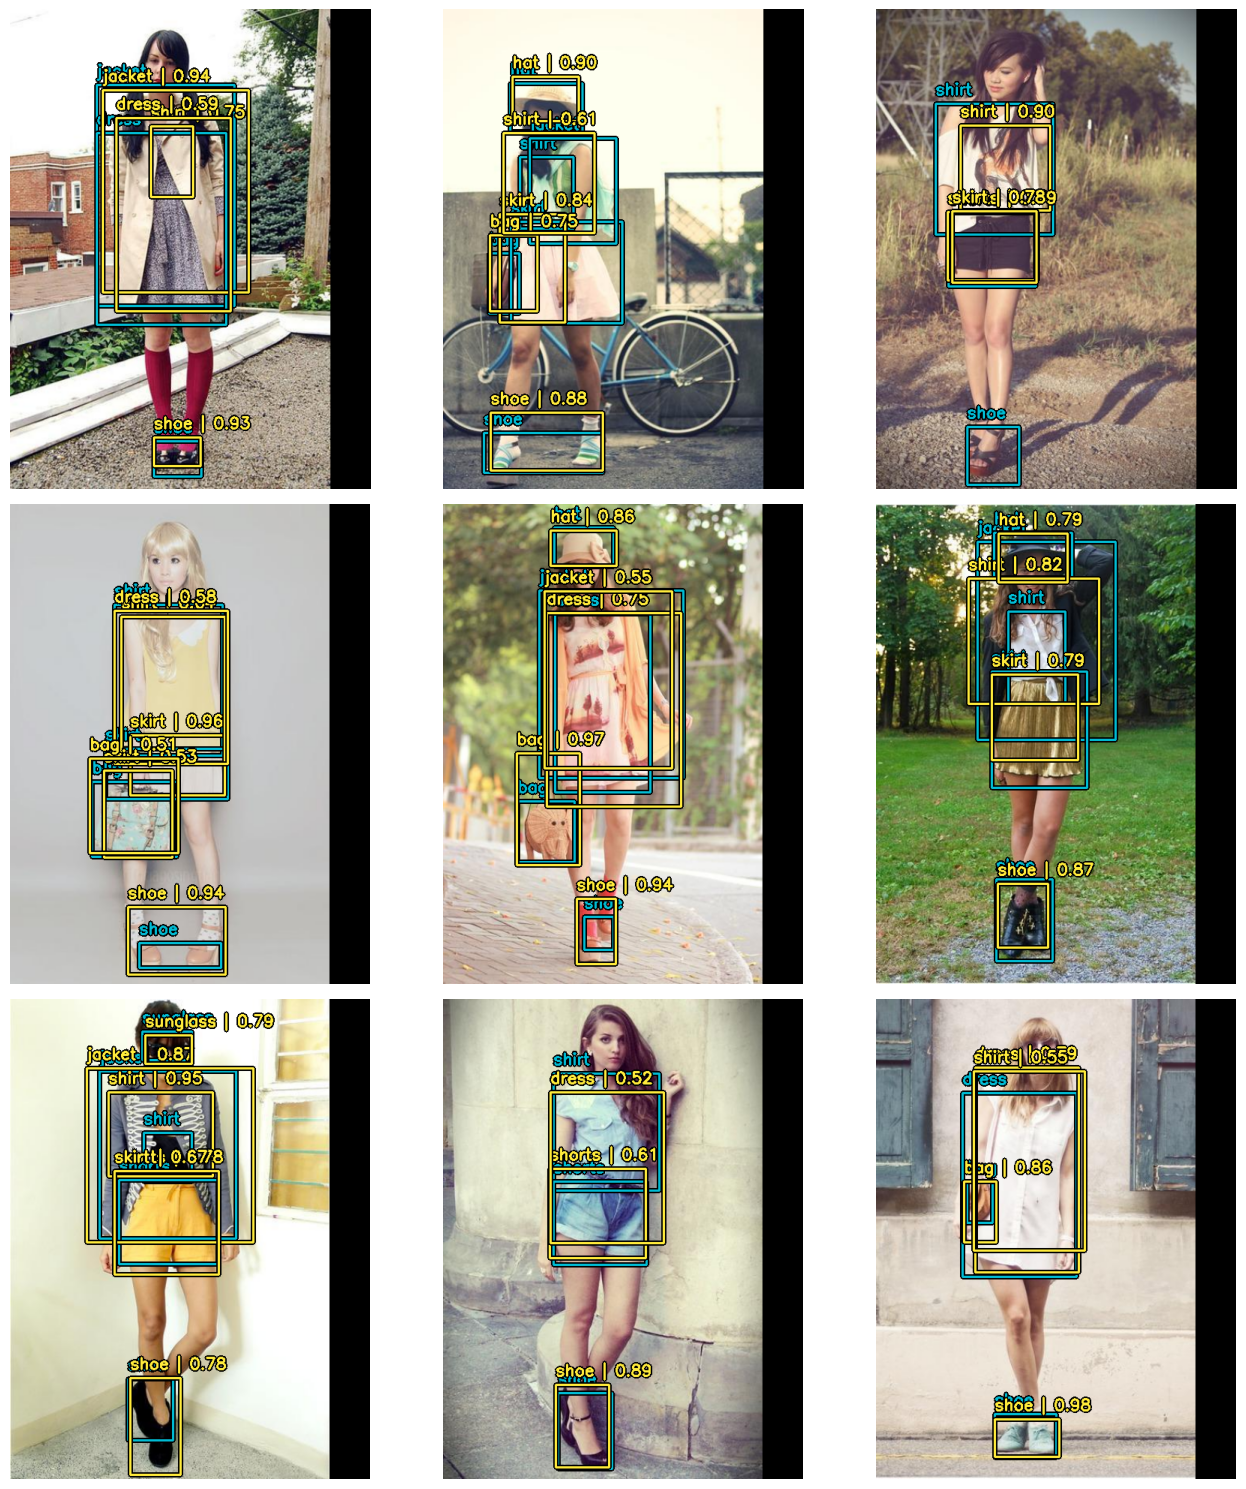

In [31]:
# enable NMS, tune for best results
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format=bounding_box_format,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.5,
)

# visualize detections, including ground truth bounding boxes
visualize_detections(model, dataset=test_ds, bounding_box_format=bounding_box_format)

# Model Improvements

Adding an quick example below of how this section could start.  Here is where we can break off and experiment with additional improvements without needing to modify previous code.

## Abdul

### Data Augmentation

In [ ]:
"""
augmenter = keras.Sequential(
    layers=[
        #keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=bounding_box_format),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format=bounding_box_format
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format=bounding_box_format, value_range=(0, 255), rows=1, cols=3
)
"""

### Prepare and Build Updated Model

In [ ]:
# prefetch data prior to training for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
NUM_EPOCHS = 20

# define optimizer
optimizer = SGD(
    learning_rate=0.01,
    momentum=0.9,
    global_clipnorm=10.0
)

In [ ]:
# define backbone model - ResNet50_Imagenet
backbone = keras_cv.models.ResNetBackbone.from_preset('resnet50_imagenet')

# build RetinaNet model using backbone
model = keras_cv.models.RetinaNet(
    backbone=backbone,
    num_classes=NUM_CLASSES,
    bounding_box_format=bounding_box_format,
)
# keep false to only train new model top
model.backbone.trainable = False

# compile the model
model.compile(
    classification_loss='focal',
    box_loss='smoothl1',
    optimizer=optimizer,
    metrics=None, # using custom metrics
)

# trian the model
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

### Evaluate Model on Sample Images

In [ ]:
# enable NMS, tune for best results
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format=bounding_box_format,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.5,
)

# visualize detections, including ground truth bounding boxes
visualize_detections(model, dataset=test_ds, bounding_box_format=bounding_box_format)

## Kayla